In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPool3D, Dense, Flatten, Dropout, ConvLSTM2D, LSTM
from tensorflow.keras.models import model_from_json

2024-10-15 11:13:02.957628: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 11:13:02.986736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 11:13:03.482273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
pip install scikit-image

/bin/bash: /home/mca/anaconda3/envs/dse/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


##### importing libraries

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import skimage.transform
from skimage import io
from sklearn.preprocessing import OneHotEncoder
import joblib

import tensorflow as tf

#### Selecting Gestures

In [3]:
gesture_list = ['Thumb Up','Thumb Down','No gesture','Swiping Right','Swiping Left','Zooming In With Full Hand']
#train
file_prefix = "new_with_thumbs"
df = pd.read_csv('./annotations/jester-v1-train.csv',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_train.csv'.format(file_prefix),sep=';',index=False)
# pd.read_csv('jester-v1-8classes_train.csv',sep=";").head()
print(df.shape)
print(df.head())
#val
df = pd.read_csv('./annotations/jester-v1-validation.csv',sep=';',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_val.csv'.format(file_prefix),sep=';',index=False)
print(df.shape)
print(df.head())

#print('Csvs done')

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size=2, image_dim=(256,256), frames_count=36, n_channels=1, base_dir='./20bn-jester-v1/', n_classes=27,validation=False):
        self.image_dim = image_dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = True 
        self.frames_count = frames_count
        self.df = pd.read_csv(file_path,sep=";")
        self.df.id = self.df.id.map(str)
        if "train" in file_path:
            self.encoder = OneHotEncoder(sparse=False)
            self.encoder.fit(self.df.labels.values[:,None])
            joblib.dump(self.encoder,"{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
            np.save("encoder_classes_{}_npy.npy".format(n_classes),self.encoder.categories_)
        else:
            self.encoder = joblib.load("{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
        self.base_dir = base_dir
        self.on_epoch_end()

    def __len__(self):
        ## Decides step_size
        return self.df.shape[0] // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = self.df.loc[indexes,"id"].to_list()
        X, y = self.__data_generation(indexes)
        return X, y 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.df.shape[0])
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size,self.frames_count, *self.image_dim, self.n_channels))
        y = np.empty((self.batch_size,1), dtype=str)
        y = []
        for i, ID in enumerate(indexes):
            files_list = self.standardize_frame_count(glob(self.base_dir + self.df.loc[ID,"id"] + "/*.jpg"),self.df.loc[ID])
            for idx,filename in enumerate(files_list):
                X[i,idx] = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(filename,color_mode='grayscale',target_size=self.image_dim))
            y.append(self.df.loc[ID,"labels"])
        encoded = self.encoder.transform(np.array(y)[:,None])
        return X,encoded
        
    def standardize_frame_count(self,files,error_check):
        shape = len(files)
        if shape < self.frames_count:
            to_add = self.frames_count - shape
            mid  = len(files)//2
            dup = [files[mid]]*to_add
            files = files[:mid] + dup + files[mid+1:]
        elif shape > self.frames_count:
            to_remove = (shape - self.frames_count)
            to_remove = int(to_remove) if int(to_remove) == to_remove else int(to_remove) + 1
            files = files[to_remove:]
        return files
    
params = {'batch_size': 56,
          'n_classes': len(gesture_list),
          'n_channels': 3,
          'image_dim': (32,32)
          }

# Generators
training_generator = DataGenerator(file_path="{}_train.csv".format(file_prefix),**params)
validation_generator = DataGenerator(file_path="{}_val.csv".format(file_prefix),**params)


(25538, 2)
        id         labels
7   136859       Thumb Up
8    68574  Swiping Right
13   20706     No gesture
14   42237     Thumb Down
22   94060     Thumb Down
(3114, 2)
       id                     labels
0    9223                   Thumb Up
2   42920               Swiping Left
3  106485                 Thumb Down
6   35341  Zooming In With Full Hand
7   94928              Swiping Right


/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import joblib
from glob import glob

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size=2, image_dim=(256, 256), frames_count=36,
                 n_channels=1, base_dir='./20bn-jester-v1/', n_classes=27, validation=False):
        self.image_dim = image_dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = True 
        self.frames_count = frames_count
        self.df = pd.read_csv(file_path, sep=";")
        self.df.id = self.df.id.map(str)

        if "train" in file_path:
            self.encoder = OneHotEncoder(sparse=False)
            self.encoder.fit(self.df.labels.values[:, None])
            joblib.dump(self.encoder, "{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
            np.save("encoder_classes_{}_npy.npy".format(n_classes), self.encoder.categories_)
        else:
            self.encoder = joblib.load("{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))

        self.base_dir = base_dir
        self.on_epoch_end()

    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y 

    def on_epoch_end(self):
        self.indexes = np.arange(self.df.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, self.frames_count, *self.image_dim, self.n_channels))
        y = []
        
        for i, ID in enumerate(indexes):
            files_list = self.standardize_frame_count(glob(self.base_dir + self.df.loc[ID, "id"] + "/*.jpg"), self.df.loc[ID])
            
            for idx, filename in enumerate(files_list):
                if filename is not None:  # Check if filename is valid
                    X[i, idx] = tf.keras.preprocessing.image.img_to_array(
                        tf.keras.preprocessing.image.load_img(filename, color_mode='grayscale', target_size=self.image_dim)
                    )
                else:
                    X[i, idx] = np.zeros((*self.image_dim, self.n_channels))  # Fill with zeros if no file

            y.append(self.df.loc[ID, "labels"])

        encoded = self.encoder.transform(np.array(y)[:, None])
        return X, encoded
        
    def standardize_frame_count(self, files, error_check):
        shape = len(files)
        
        if shape < self.frames_count:
            to_add = self.frames_count - shape
            if shape > 0:
                mid = len(files) // 2
                dup = [files[mid]] * to_add
                files = files[:mid] + dup + files[mid + 1:]
            else:
                files = [None] * self.frames_count  # Handle case with no files
        elif shape > self.frames_count:
            to_remove = shape - self.frames_count
            files = files[to_remove:]

        return files

# Parameters
params = {
    'batch_size': 56,
    'n_classes': len(gesture_list),
    'n_channels': 3,
    'image_dim': (32, 32)
}

# Generators
training_generator = DataGenerator(file_path="{}_train.csv".format(file_prefix), **params)
validation_generator = DataGenerator(file_path="{}_val.csv".format(file_prefix), **params)


/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPool3D, Dense, Flatten, Dropout, ConvLSTM2D, LSTM
from tensorflow.keras.models import model_from_json

In [ ]:
def build_model(n_classes=6):
    momentum = 0.99
    
    model = tf.keras.Sequential()
    model.add(Conv3D(64,kernel_size=3,strides=1,padding='valid',activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1,2,2),padding='same'))

    model.add(Conv3D(128,kernel_size=3,strides=1,padding='valid',activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2,2,2),padding='same'))

    model.add(Conv3D(256,kernel_size=3,strides=1,padding='valid',activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2,2,2),padding='same'))


    model.add(Conv3D(256,kernel_size=3,strides=1,padding='valid',activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2,2,2),padding='same'))


    model.add(Flatten())

    model.add(Dense(512,activation='elu'))
    model.add(Dense(n_classes,activation='softmax'))
    #batch_size,n_classes
    return model

model = build_model(6)
optimizer = SGD(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

history=model.fit(training_generator,validation_data=validation_generator,validation_steps=1024,epochs=300,verbose=1)


2024-10-15 11:13:07.714750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-15 11:13:07.733083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-15 11:13:07.733262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/300


2024-10-15 11:13:11.084689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-15 11:13:13.333698: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0bf84c2ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-15 11:13:13.333717: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-15 11:13:13.373591: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 [==============================] - 79s 163ms/step - loss: 1.8424 - acc: 0.1746 - val_loss: 1.8207 - val_acc: 0.1873
Epoch 2/300


2024-10-15 11:14:29.724536: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6753711421851666655
2024-10-15 11:14:29.724630: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11489751092452024990
2024-10-15 11:14:29.724664: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13333849225227941282


456/456 [==============================] - 72s 157ms/step - loss: 1.7752 - acc: 0.1895
Epoch 3/300
456/456 [==============================] - 72s 157ms/step - loss: 1.7520 - acc: 0.1949
Epoch 4/300
456/456 [==============================] - 72s 157ms/step - loss: 1.7419 - acc: 0.2021
Epoch 5/300
456/456 [==============================] - 71s 156ms/step - loss: 1.7307 - acc: 0.2074
Epoch 6/300
456/456 [==============================] - 71s 156ms/step - loss: 1.7215 - acc: 0.2123
Epoch 7/300
456/456 [==============================] - 72s 157ms/step - loss: 1.7157 - acc: 0.2090
Epoch 8/300
456/456 [==============================] - 71s 156ms/step - loss: 1.7122 - acc: 0.2110
Epoch 9/300
456/456 [==============================] - 70s 154ms/step - loss: 1.7032 - acc: 0.2157
Epoch 10/300
456/456 [==============================] - 71s 155ms/step - loss: 1.7011 - acc: 0.2157
Epoch 11/300
456/456 [==============================] - 72s 158ms/step - loss: 1.6990 - acc: 0.2194
Epoch 12/300
456/456

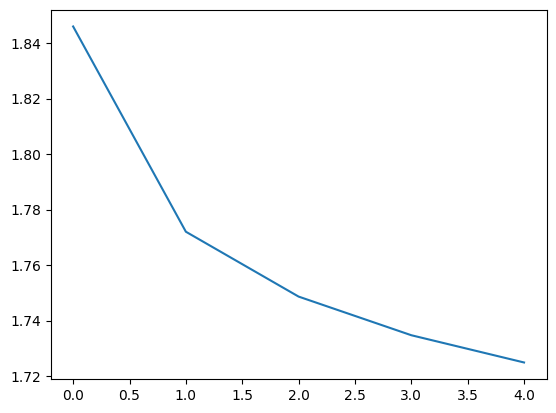

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])

In [5]:
def save_model(model,file_path):
    model_json = model.to_json()
    with open(file_path+'.json', "w") as json_file:
        json_file.write(model_json)
    model.save_weights(file_path+'.h5')
save_model(model,'{}_model'.format(file_prefix))


model.evaluate(validation_generator)

/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
